In [32]:
import pandas as pd
import numpy as np

import gurobipy as gb
from gurobipy import *
import matplotlib.pyplot as plt

**Decision Variable**

Let  $x_i$  be the budget allocated to campaign  $i$.

Let $z_i$  be a binary variable that indicates whether campaign  $i$  is selected (1) or not (0).


1. Objective Function (Multi-Rank）

Primary Objective:

**Maximize Total Number of conversion:**

$$\text{Maximize} \quad \sum_{i=1}^n \text{ConversionRate}_i \cdot \text{Clicks}_i \cdot z_i$$

**Secondary Objective: Maximize Profits(ROI * AQUSITION COST -AQUISITION COST)**

$$\text{Maximize} \quad \sum_{i=1}^n (\text{ROI}_i Cost_i - Cost_i) \cdot z_i$$

**Budget Constraints:**

$$\sum_{i=1}^n x_i \leq \text{TotalBudget}$$

**Engagement Score Constraint:**

$$\sum_i z_i \cdot \text{EngagementScore}_i \geq \text{MinimumEngagement}, \quad \forall i$$

**Target Audience:**

Let:
$\text{Target Channel}_i$ : Campaigns targeting specific channel  i .

$z_i \in \{0, 1\}$ : Binary variable indicating whether campaign  i  is active.

$\text{MaxCampaigns}_j$ : The maximum number of campaigns allowed for target audience  j .

$\text{MaxCampaigns}_\text{Channel}$ : Maximum number of campaigns allowed for the desired channel.

Mathematical Formulation:

$$\sum_i z_i \cdot \text{Target Channel}_i \geq \text{MinCampaigns}_j, \quad \forall j$$

**Target Channel:**

Let:
$\text{Target Audience}_i$ : Campaigns targeting specific audience  i .

$z_i \in \{0, 1\}$ : Binary variable indicating whether campaign  i  is active.

$\text{MaxCampaigns}_j$ : The maximum number of campaigns allowed for channel  j .

$\text{MaxCampaigns}_\text{Audience}$ : Maximum number of campaigns allowed for the target audience.

Mathematical Formulation:

$$\sum_i z_i \cdot \text{Target Audience}_i \geq \text{MinCampaigns}_j, \quad \forall j$$


**Goal Constriaints: maximum compaigns per goal.**

Let:

$\text{Segment}_j$ : Each goal (e.g., age groups or demographics).

$S_j$ : The set of campaigns targeting goal  j .

$\text{MaxCampaigns}_j$ : The maximum number of campaigns allowed for goal  j .

$z_i \in \{0, 1\}$ : A binary variable indicating whether campaign  i  is active (1 if active, 0 otherwise).

Mathematical Formulation:

$$\sum_{i \in S_j} z_i \cdot \text{Goal}_i\leq \text{MaxCampaigns}_j, \quad \forall j$$




**Duration Constraints: maximum compaigns per duration.**

Let:

$\text{Period}_k$ : Each duration (e.g., 15days, 30days, etc.).

$T_k$ : The set of campaigns active in duration  k .

$\text{MaxCampaigns}_k$ : Maximum number of campaigns allowed for duration  k .

$z_i \in \{0, 1\}$ : Binary variable indicating whether campaign  i  is active.

Mathematical Formulation:

$$\sum_{i \in T_j} z_i \cdot \text{Duration}_i\leq \text{MaxCampaigns}_j, \quad \forall j$$


$z_i \in \{0, 1\}$ 

$x_i \geq 0 $

# Data Preprocessing

In [16]:
#Read the data
data = pd.read_csv("Aura_Align_Preprocessed.csv")
df = data.sample(n=400, random_state=42).reset_index(drop=True)

duration = df['Duration']
conversion = df['Conversion_Rate']
cost = df['Acquisition_Cost']
ROI = df['ROI']
clicks = df['Clicks']
engagement = df['Engagement_Score']
campaign_ids = df['Campaign_ID']
campaign_goals = df['Campaign_Goal']

#columns_to_dummify = ["Target_Audience", "Location", "Channel_Used"]
#df= pd.get_dummies(df, columns=columns_to_dummify, drop_first=False)
df['conversion_num'] = df['Clicks']*df['Conversion_Rate']
conversion_num = df['conversion_num']

In [17]:
df

,Unnamed: 0,Campaign_ID,Target_Audience,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Company,Year,Month,Day,conversion_num
0,169021,163512,Men 18-24,Product Launch,45 Days,Instagram,0.02,8673.66,0.300000,New York,English,22754,68918,3,Health,Aura Align,2022,9,30,455.08
1,13019,127633,Women 45-60,Brand Awareness,15 Days,Instagram,0.10,591.11,0.860000,Los Angeles,English,2214,8077,1,Health,Aura Align,2022,12,15,221.40
2,161877,595789,Women 45-60,Market Expansion,45 Days,Instagram,0.14,8327.45,4.450000,Los Angeles,Spanish,21813,66132,5,Health,Aura Align,2022,10,3,3053.82
3,11669,899942,Women 35-44,Increase Sales,15 Days,Facebook,0.07,500.00,3.180000,Austin,English,2036,7550,10,Health,Aura Align,2022,3,7,142.52
4,45197,670963,Women 18-24,Product Launch,15 Days,Facebook,0.07,2636.04,4.110000,Las Vegas,Spanish,6450,20626,6,Health,Aura Align,2022,5,8,451.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,161402,171439,All Ages,Increase Sales,45 Days,Facebook,0.10,8303.78,5.220000,Austin,Spanish,21751,65946,10,Health,Aura Align,2022,12,17,2175.10
396,186526,855355,Women 25-34,Market Expansion,45 Days,Instagram,0.04,9528.83,1.060000,Las Vegas,Spanish,25059,75745,10,Health,Aura Align,2022,6,27,1002.36
397,20706,738333,Men 18-24,Market Expansion,15 Days,Pinterest,0.12,1201.05,1.072484,Miami,English,1894,7150,1,Health,Aura Align,2022,4,4,227.28
398,31377,205822,Men 18-24,Brand Awareness,15 Days,Pinterest,0.03,1885.26,1.142195,New York,English,2719,9837,1,Health,Aura Align,2022,3,25,81.57


# Correlation Matrix

In [18]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numerical_df.corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                  Unnamed: 0  Campaign_ID  Conversion_Rate  Acquisition_Cost  \
Unnamed: 0          1.000000    -0.055312         0.078666          0.999686   
Campaign_ID        -0.055312     1.000000         0.016137         -0.056577   
Conversion_Rate     0.078666     0.016137         1.000000          0.078215   
Acquisition_Cost    0.999686    -0.056577         0.078215          1.000000   
ROI                -0.027609    -0.003301        -0.010033         -0.025462   
Clicks              0.928967    -0.055909         0.044000          0.928927   
Impressions         0.946069    -0.056318         0.049024          0.945999   
Engagement_Score    0.020229     0.034365        -0.071137          0.019181   
Year                     NaN          NaN              NaN               NaN   
Month              -0.043206    -0.000062        -0.043316         -0.043045   
Day                -0.020243    -0.075863         0.016938         -0.019033   
conversion_num      

# Data Exploration

In [19]:
columns_to_check = ["Target_Audience", "Location", "Channel_Used"]

for column in columns_to_check:
    unique_values = df[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Target_Audience': ['Men 18-24' 'Women 45-60' 'Women 35-44' 'Women 18-24' 'Men 45-60'
 'Men 25-34' 'Women 25-34' 'Men 35-44' 'All Ages']
Unique values in 'Location': ['New York' 'Los Angeles' 'Austin' 'Las Vegas' 'Miami']
Unique values in 'Channel_Used': ['Instagram' 'Facebook' 'Pinterest' 'Twitter']


In [20]:
# Count occurrences for each category in the specified columns
columns_to_check = ["Target_Audience", "Location",'Duration','Campaign_Goal',
                   'Channel_Used']

for column in columns_to_check:
    print(f"Category counts in '{column}':")
    print(df[column].value_counts())
    print()


Category counts in 'Target_Audience':
Target_Audience
Women 35-44    53
Women 45-60    52
Women 25-34    51
Men 18-24      50
Women 18-24    46
Men 35-44      41
All Ages       41
Men 25-34      40
Men 45-60      26
Name: count, dtype: int64

Category counts in 'Location':
Location
Los Angeles    90
Miami          81
Las Vegas      79
New York       75
Austin         75
Name: count, dtype: int64

Category counts in 'Duration':
Duration
30 Days    110
15 Days    106
45 Days     95
60 Days     89
Name: count, dtype: int64

Category counts in 'Campaign_Goal':
Campaign_Goal
Brand Awareness     107
Market Expansion    107
Product Launch      104
Increase Sales       82
Name: count, dtype: int64

Category counts in 'Channel_Used':
Channel_Used
Facebook     107
Instagram    106
Pinterest     98
Twitter       89
Name: count, dtype: int64



# Final Model

In [21]:
# Final Model Increase Sales
model = gb.Model("AuraAlign_Advertising_Optimization")

# Parameters (you'll need to load these from your dataset)
num_campaigns = len(campaign_ids)
# Example constraints for budget, segments, and time periods
total_budget = 1000000  # Define total budget

duration_limits = {
    '15 Days': 30,  # Example max budget allocation for campaigns of 15 days
    '30 Days':30,  # Example max budget allocation for campaigns of 30 days
    '45 Days': 30,
    '60 Days': 30
}


max_spend_by_goal = {
    'Brand Awareness': 22, 
    'Increase Sales': 50,
    'Market Expansion': 20,
    'Product Launch': 20
}

Audience_targets= {
    "Women 35-44": 12,
    "Women 45-60": 12,
    "Women 25-34": 12,
    "Men 18-24": 12,
    "Women 18-24": 16,
    "Men 35-44": 5,
    "All Ages": 5,
    "Men 25-34":3,
    "Men 45-60": 1
}

Channel_targets = {
    "Facebook": 35,
    "Instagram": 35,
    "Pinterest": 3,
    "Twitter":15
}


# Variables
x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)
z = model.addVars(num_campaigns, vtype=GRB.BINARY, name="CampaignSelection")

# Primary Objective: Maximize Total number of Conversion
primary_objective = gb.quicksum(conversion[i] * clicks[i]*z[i] for i in range(num_campaigns))
model.setObjectiveN(primary_objective, index=0, priority=2)  # Highest priority

# Secondary Objective: Maximize Revenue = ROI * Cost + Cost)
revenue = [ROI[i] * cost[i] + cost[i] for i in range(num_campaigns)]
secondary_objective = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
model.setObjectiveN(secondary_objective, index=1, priority=1)  # Second priority

# Constraints

# Total budget constraint
model.addConstr(gb.quicksum(cost[i]*z[i] for i in range(num_campaigns)) <= total_budget, "BudgetConstraint")


# Ensure budget allocation for each campaign is only considered if the campaign is selected
for i in range(num_campaigns):
    model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")

# Maximum Spend Constraints by Campaign Goal
for goal, target in max_spend_by_goal.items():
    goal_indices = df[df['Campaign_Goal'] == goal].index  # Indices of campaigns with the specific goal
    model.addConstr(gb.quicksum(z[i] for i in goal_indices) <= target, f"MaxSpend_{goal}")

# Duration Constraints: Ensure the total budget for each duration does not exceed the specified limit
for duration_type, target in duration_limits.items():
    duration_indices = df[df['Duration'] == duration_type].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in duration_indices) <= target, f"DurationLimit_{duration_type}")

for audience, target in Audience_targets.items():
    audience_indices = df[df['Target_Audience'] == audience].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in audience_indices) >= target, f"AudienceTarget_{audience}")

for channel, target in Channel_targets.items():
    channel_indices = df[df['Channel_Used'] == channel].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in channel_indices) >= target, f"ChannelTarget_{channel}")

# Engagement Score Constraints (optional
# Assume a minimum engagement score constraint for selected campaigns

min_engagement = 850
model.addConstr(gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns))>= min_engagement, f"EngagementConstraint_{i}")
    
model.addConstr(gb.quicksum(z[i] for i in range(num_campaigns)) == 100, "SelectionConstraint")


# Optimize the model
model.optimize()

# Display results if an optimal solution is found
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found:")
    
    total_conversion_rate = primary_objective.getValue()
    total_revenue = secondary_objective.getValue()
    total_allocated_budget = sum(x[i].X for i in range(num_campaigns))

    
    print("Total Conversion Rate:", round(total_conversion_rate,2))
    print("Total Revenue:", round(total_revenue,2))
    print("Total Budget Allocated:", round(total_allocated_budget,2))
    print("Total Profit:", round(total_revenue - total_allocated_budget,2))

    goal_counts = {
        'Brand Awareness': 0,
        'Increase Sales': 0,
        'Market Expansion': 0,
        'Product Launch': 0
    }

    # Print selected campaigns and their details
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            goal = df.loc[i, 'Campaign_Goal']
            # Increment the counter for the corresponding goal
            if goal in goal_counts:
                goal_counts[goal] += 1
    print("\nNumber of selected campaigns by goal:")
    for goal, count in goal_counts.items():
        print(f"{goal}: {count}")
    '''
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            print(f"""Campaign {campaign_ids[i]}: Budget Allocated = {x[i].X}, Number of Conversion= {conversion[i]*clicks[i]}, Profit = {profits[i]}, 
             Engagement = {engagement[i]}""") 
    '''
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 424 rows, 800 columns and 3600 nonzeros
Model fingerprint: 0x01dca8ac
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 400 rows and 400 columns
Presolve time: 0.00s
Presolved: 24 rows, 400 columns, 2644 nonzeros
---------------------------------------------------------

# Goal of Market Expansion

In [22]:
# Market Expansion
model = gb.Model("AuraAlign_Advertising_Optimization")

# Parameters (you'll need to load these from your dataset)
num_campaigns = len(campaign_ids)
# Example constraints for budget, segments, and time periods
total_budget = 1000000  # Define total budget

duration_limits = {
    '15 Days': 30,  # Example max budget allocation for campaigns of 15 days
    '30 Days':30,  # Example max budget allocation for campaigns of 30 days
    '45 Days': 30,
    '60 Days': 30
}


max_spend_by_goal = {
    'Brand Awareness': 20,
    'Increase Sales': 20,
    'Market Expansion': 50,
    'Product Launch': 20
}

Audience_targets= {
    "Women 35-44": 12,
    "Women 45-60": 12,
    "Women 25-34": 12,
    "Men 18-24": 12,
    "Women 18-24": 16,
    "Men 35-44": 5,
    "All Ages": 5,
    "Men 25-34":3,
    "Men 45-60": 1
}

Channel_targets = {
    "Facebook": 35,
    "Instagram": 35,
    "Pinterest": 3,
    "Twitter":15
}


# Variables
x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)
z = model.addVars(num_campaigns, vtype=GRB.BINARY, name="CampaignSelection")

# Primary Objective: Maximize Total number of Conversion
primary_objective = gb.quicksum(conversion[i] * clicks[i]*z[i] for i in range(num_campaigns))
model.setObjectiveN(primary_objective, index=0, priority=2)  # Highest priority

# Secondary Objective: Maximize Revenue = ROI * Cost + Cost)
revenue = [ROI[i] * cost[i] + cost[i] for i in range(num_campaigns)]
secondary_objective = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
model.setObjectiveN(secondary_objective, index=1, priority=1)  # Second priority

# Constraints

# Total budget constraint
model.addConstr(gb.quicksum(cost[i]*z[i] for i in range(num_campaigns)) <= total_budget, "BudgetConstraint")


# Ensure budget allocation for each campaign is only considered if the campaign is selected
for i in range(num_campaigns):
    model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")

# Maximum Spend Constraints by Campaign Goal
for goal, target in max_spend_by_goal.items():
    goal_indices = df[df['Campaign_Goal'] == goal].index  # Indices of campaigns with the specific goal
    model.addConstr(gb.quicksum(z[i] for i in goal_indices) <= target, f"MaxSpend_{goal}")

# Duration Constraints: Ensure the total budget for each duration does not exceed the specified limit
for duration_type, target in duration_limits.items():
    duration_indices = df[df['Duration'] == duration_type].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in duration_indices) <= target, f"DurationLimit_{duration_type}")

for audience, target in Audience_targets.items():
    audience_indices = df[df['Target_Audience'] == audience].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in audience_indices) >= target, f"AudienceTarget_{audience}")

for channel, target in Channel_targets.items():
    channel_indices = df[df['Channel_Used'] == channel].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in channel_indices) >= target, f"ChannelTarget_{channel}")

# Engagement Score Constraints (optional
# Assume a minimum engagement score constraint for selected campaigns

min_engagement = 850
model.addConstr(gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns))>= min_engagement, f"EngagementConstraint_{i}")
    
model.addConstr(gb.quicksum(z[i] for i in range(num_campaigns)) == 100, "SelectionConstraint")


# Optimize the model
model.optimize()

# Display results if an optimal solution is found
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found:")
    
    total_conversion_rate = primary_objective.getValue()
    total_revenue = secondary_objective.getValue()
    total_allocated_budget = sum(x[i].X for i in range(num_campaigns))

    
    print("Total Conversion Rate:", round(total_conversion_rate,2))
    print("Total Revenue:", round(total_revenue,2))
    print("Total Budget Allocated:", round(total_allocated_budget,2))
    print("Total Profit:", round(total_revenue - total_allocated_budget,2))

    goal_counts = {
        'Brand Awareness': 0,
        'Increase Sales': 0,
        'Market Expansion': 0,
        'Product Launch': 0
    }

    # Print selected campaigns and their details
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            goal = df.loc[i, 'Campaign_Goal']
            # Increment the counter for the corresponding goal
            if goal in goal_counts:
                goal_counts[goal] += 1
    print("\nNumber of selected campaigns by goal:")
    for goal, count in goal_counts.items():
        print(f"{goal}: {count}")
    '''
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            print(f"""Campaign {campaign_ids[i]}: Budget Allocated = {x[i].X}, Number of Conversion= {conversion[i]*clicks[i]}, Profit = {profits[i]}, 
             Engagement = {engagement[i]}""") 
    '''
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 424 rows, 800 columns and 3600 nonzeros
Model fingerprint: 0x800c6bbe
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 400 rows and 400 columns
Presolve time: 0.00s
Presolved: 24 rows, 400 columns, 2644 nonzeros
---------------------------------------------------------

# Goal of Brand Awareness

In [23]:
#Brand Awareness
model = gb.Model("AuraAlign_Advertising_Optimization")

# Parameters (you'll need to load these from your dataset)
num_campaigns = len(campaign_ids)
# Example constraints for budget, segments, and time periods
total_budget = 1000000  # Define total budget

duration_limits = {
    '15 Days': 30,  # Example max budget allocation for campaigns of 15 days
    '30 Days':30,  # Example max budget allocation for campaigns of 30 days
    '45 Days': 30,
    '60 Days': 30
}


max_spend_by_goal = {
    'Brand Awareness': 50,
    'Increase Sales': 20,
    'Market Expansion': 20,
    'Product Launch': 20
}

Audience_targets= {
    "Women 35-44": 12,
    "Women 45-60": 12,
    "Women 25-34": 12,
    "Men 18-24": 12,
    "Women 18-24": 16,
    "Men 35-44": 5,
    "All Ages": 5,
    "Men 25-34":3,
    "Men 45-60": 1
}

Channel_targets = {
    "Facebook": 35,
    "Instagram": 35,
    "Pinterest": 3,
    "Twitter":15
}


# Variables
x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)
z = model.addVars(num_campaigns, vtype=GRB.BINARY, name="CampaignSelection")

# Primary Objective: Maximize Total number of Conversion
primary_objective = gb.quicksum(conversion[i] * clicks[i]*z[i] for i in range(num_campaigns))
model.setObjectiveN(primary_objective, index=0, priority=2)  # Highest priority

# Secondary Objective: Maximize Revenue = ROI * Cost + Cost)
revenue = [ROI[i] * cost[i] + cost[i] for i in range(num_campaigns)]
secondary_objective = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
model.setObjectiveN(secondary_objective, index=1, priority=1)  # Second priority

# Constraints

# Total budget constraint
model.addConstr(gb.quicksum(cost[i]*z[i] for i in range(num_campaigns)) <= total_budget, "BudgetConstraint")


# Ensure budget allocation for each campaign is only considered if the campaign is selected
for i in range(num_campaigns):
    model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")

# Maximum Spend Constraints by Campaign Goal
for goal, target in max_spend_by_goal.items():
    goal_indices = df[df['Campaign_Goal'] == goal].index  # Indices of campaigns with the specific goal
    model.addConstr(gb.quicksum(z[i] for i in goal_indices) <= target, f"MaxSpend_{goal}")

# Duration Constraints: Ensure the total budget for each duration does not exceed the specified limit
for duration_type, target in duration_limits.items():
    duration_indices = df[df['Duration'] == duration_type].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in duration_indices) <= target, f"DurationLimit_{duration_type}")

for audience, target in Audience_targets.items():
    audience_indices = df[df['Target_Audience'] == audience].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in audience_indices) >= target, f"AudienceTarget_{audience}")

for channel, target in Channel_targets.items():
    channel_indices = df[df['Channel_Used'] == channel].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in channel_indices) >= target, f"ChannelTarget_{channel}")

# Engagement Score Constraints (optional
# Assume a minimum engagement score constraint for selected campaigns

min_engagement = 850
model.addConstr(gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns))>= min_engagement, f"EngagementConstraint_{i}")
    
model.addConstr(gb.quicksum(z[i] for i in range(num_campaigns)) == 100, "SelectionConstraint")


# Optimize the model
model.optimize()

# Display results if an optimal solution is found
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found:")
    
    total_conversion_rate = primary_objective.getValue()
    total_revenue = secondary_objective.getValue()
    total_allocated_budget = sum(x[i].X for i in range(num_campaigns))

    
    print("Total Conversion Rate:", round(total_conversion_rate,2))
    print("Total Revenue:", round(total_revenue,2))
    print("Total Budget Allocated:", round(total_allocated_budget,2))
    print("Total Profit:", round(total_revenue - total_allocated_budget,2))

    goal_counts = {
        'Brand Awareness': 0,
        'Increase Sales': 0,
        'Market Expansion': 0,
        'Product Launch': 0
    }

    # Print selected campaigns and their details
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            goal = df.loc[i, 'Campaign_Goal']
            # Increment the counter for the corresponding goal
            if goal in goal_counts:
                goal_counts[goal] += 1
    print("\nNumber of selected campaigns by goal:")
    for goal, count in goal_counts.items():
        print(f"{goal}: {count}")
    '''
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            print(f"""Campaign {campaign_ids[i]}: Budget Allocated = {x[i].X}, Number of Conversion= {conversion[i]*clicks[i]}, Profit = {profits[i]}, 
             Engagement = {engagement[i]}""") 
    '''
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 424 rows, 800 columns and 3600 nonzeros
Model fingerprint: 0xab16fcca
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 400 rows and 400 columns
Presolve time: 0.00s
Presolved: 24 rows, 400 columns, 2644 nonzeros
---------------------------------------------------------

# Goal of Product Launch

In [24]:
#Product Launch
model = gb.Model("AuraAlign_Advertising_Optimization")

# Parameters (you'll need to load these from your dataset)
num_campaigns = len(campaign_ids)
# Example constraints for budget, segments, and time periods
total_budget = 1000000  # Define total budget

duration_limits = {
    '15 Days': 30,  # Example max budget allocation for campaigns of 15 days
    '30 Days':30,  # Example max budget allocation for campaigns of 30 days
    '45 Days': 30,
    '60 Days': 30
}


max_spend_by_goal = {
    'Brand Awareness': 22,
    'Increase Sales': 20,
    'Market Expansion': 20,
    'Product Launch': 50
}

Audience_targets= {
    "Women 35-44": 12,
    "Women 45-60": 12,
    "Women 25-34": 12,
    "Men 18-24": 12,
    "Women 18-24": 16,
    "Men 35-44": 5,
    "All Ages": 5,
    "Men 25-34":3,
    "Men 45-60": 1
}

Channel_targets = {
    "Facebook": 35,
    "Instagram": 35,
    "Pinterest": 3,
    "Twitter":15
}


# Variables
x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)
z = model.addVars(num_campaigns, vtype=GRB.BINARY, name="CampaignSelection")

# Primary Objective: Maximize Total number of Conversion
primary_objective = gb.quicksum(conversion[i] * clicks[i]*z[i] for i in range(num_campaigns))
model.setObjectiveN(primary_objective, index=0, priority=2)  # Highest priority

# Secondary Objective: Maximize Revenue = ROI * Cost + Cost)
revenue = [ROI[i] * cost[i] + cost[i] for i in range(num_campaigns)]
secondary_objective = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
model.setObjectiveN(secondary_objective, index=1, priority=1)  # Second priority

# Constraints

# Total budget constraint
model.addConstr(gb.quicksum(cost[i]*z[i] for i in range(num_campaigns)) <= total_budget, "BudgetConstraint")


# Ensure budget allocation for each campaign is only considered if the campaign is selected
for i in range(num_campaigns):
    model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")

# Maximum Spend Constraints by Campaign Goal
for goal, target in max_spend_by_goal.items():
    goal_indices = df[df['Campaign_Goal'] == goal].index  # Indices of campaigns with the specific goal
    model.addConstr(gb.quicksum(z[i] for i in goal_indices) <= target, f"MaxSpend_{goal}")

# Duration Constraints: Ensure the total budget for each duration does not exceed the specified limit
for duration_type, target in duration_limits.items():
    duration_indices = df[df['Duration'] == duration_type].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in duration_indices) <= target, f"DurationLimit_{duration_type}")

for audience, target in Audience_targets.items():
    audience_indices = df[df['Target_Audience'] == audience].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in audience_indices) >= target, f"AudienceTarget_{audience}")

for channel, target in Channel_targets.items():
    channel_indices = df[df['Channel_Used'] == channel].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in channel_indices) >= target, f"ChannelTarget_{channel}")

# Engagement Score Constraints (optional
# Assume a minimum engagement score constraint for selected campaigns

min_engagement = 850
model.addConstr(gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns))>= min_engagement, f"EngagementConstraint_{i}")
    
model.addConstr(gb.quicksum(z[i] for i in range(num_campaigns)) == 100, "SelectionConstraint")


# Optimize the model
model.optimize()

# Display results if an optimal solution is found
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found:")
    
    total_conversion_rate = primary_objective.getValue()
    total_revenue = secondary_objective.getValue()
    total_allocated_budget = sum(x[i].X for i in range(num_campaigns))

    
    print("Total Conversion Rate:", round(total_conversion_rate,2))
    print("Total Revenue:", round(total_revenue,2))
    print("Total Budget Allocated:", round(total_allocated_budget,2))
    print("Total Profit:", round(total_revenue - total_allocated_budget,2))

    goal_counts = {
        'Brand Awareness': 0,
        'Increase Sales': 0,
        'Market Expansion': 0,
        'Product Launch': 0
    }

    # Print selected campaigns and their details
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            goal = df.loc[i, 'Campaign_Goal']
            # Increment the counter for the corresponding goal
            if goal in goal_counts:
                goal_counts[goal] += 1
    print("\nNumber of selected campaigns by goal:")
    for goal, count in goal_counts.items():
        print(f"{goal}: {count}")
    '''
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            print(f"""Campaign {campaign_ids[i]}: Budget Allocated = {x[i].X}, Number of Conversion= {conversion[i]*clicks[i]}, Profit = {profits[i]}, 
             Engagement = {engagement[i]}""") 
    '''
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 424 rows, 800 columns and 3600 nonzeros
Model fingerprint: 0x7a44c0ea
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 400 rows and 400 columns
Presolve time: 0.00s
Presolved: 24 rows, 400 columns, 2644 nonzeros
---------------------------------------------------------

# Remove Goal Constraint

In [25]:
#No goal
model = gb.Model("AuraAlign_Advertising_Optimization")

# Parameters (you'll need to load these from your dataset)
num_campaigns = len(campaign_ids)
# Example constraints for budget, segments, and time periods
total_budget = 1000000  # Define total budget

duration_limits = {
    '15 Days': 30,  # Example max budget allocation for campaigns of 15 days
    '30 Days':30,  # Example max budget allocation for campaigns of 30 days
    '45 Days': 30,
    '60 Days': 30
}


max_spend_by_goal = {
    'Brand Awareness': 0,
    'Increase Sales': 0,
    'Market Expansion': 0,
    'Product Launch': 0
}

Audience_targets= {
    "Women 35-44": 12,
    "Women 45-60": 12,
    "Women 25-34": 12,
    "Men 18-24": 12,
    "Women 18-24": 16,
    "Men 35-44": 5,
    "All Ages": 5,
    "Men 25-34":3,
    "Men 45-60": 1
}

Channel_targets = {
    "Facebook": 35,
    "Instagram": 35,
    "Pinterest": 3,
    "Twitter":15
}


# Variables
x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)
z = model.addVars(num_campaigns, vtype=GRB.BINARY, name="CampaignSelection")

# Primary Objective: Maximize Total number of Conversion
primary_objective = gb.quicksum(conversion[i] * clicks[i]*z[i] for i in range(num_campaigns))
model.setObjectiveN(primary_objective, index=0, priority=2)  # Highest priority

# Secondary Objective: Maximize Revenue = ROI * Cost + Cost)
revenue = [ROI[i] * cost[i] + cost[i] for i in range(num_campaigns)]
secondary_objective = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
model.setObjectiveN(secondary_objective, index=1, priority=1)  # Second priority

# Constraints

# Total budget constraint
model.addConstr(gb.quicksum(cost[i]*z[i] for i in range(num_campaigns)) <= total_budget, "BudgetConstraint")


# Ensure budget allocation for each campaign is only considered if the campaign is selected
for i in range(num_campaigns):
    model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")
'''
# Maximum Spend Constraints by Campaign Goal
for goal, target in max_spend_by_goal.items():
    goal_indices = df[df['Campaign_Goal'] == goal].index  # Indices of campaigns with the specific goal
    model.addConstr(gb.quicksum(z[i] for i in goal_indices) <= target, f"MaxSpend_{goal}")
'''
# Duration Constraints: Ensure the total budget for each duration does not exceed the specified limit
for duration_type, target in duration_limits.items():
    duration_indices = df[df['Duration'] == duration_type].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in duration_indices) <= target, f"DurationLimit_{duration_type}")

for audience, target in Audience_targets.items():
    audience_indices = df[df['Target_Audience'] == audience].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in audience_indices) >= target, f"AudienceTarget_{audience}")

for channel, target in Channel_targets.items():
    channel_indices = df[df['Channel_Used'] == channel].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in channel_indices) >= target, f"ChannelTarget_{channel}")

# Engagement Score Constraints (optional
# Assume a minimum engagement score constraint for selected campaigns

min_engagement = 850
model.addConstr(gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns))>= min_engagement, f"EngagementConstraint_{i}")
    
model.addConstr(gb.quicksum(z[i] for i in range(num_campaigns)) == 100, "SelectionConstraint")


# Optimize the model
model.optimize()

# Display results if an optimal solution is found
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found:")
    
    total_conversion_rate = primary_objective.getValue()
    total_revenue = secondary_objective.getValue()
    total_allocated_budget = sum(x[i].X for i in range(num_campaigns))

    
    print("Total Conversion Rate:", round(total_conversion_rate,2))
    print("Total Revenue:", round(total_revenue,2))
    print("Total Budget Allocated:", round(total_allocated_budget,2))
    print("Total Profit:", round(total_revenue - total_allocated_budget,2))

    print("\nNumber of selected campaigns by goal:")
    for goal, count in goal_counts.items():
        print(f"{goal}: {count}")

    '''
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            print(f"""Campaign {campaign_ids[i]}: Budget Allocated = {x[i].X}, Number of Conversion= {conversion[i]*clicks[i]}, Profit = {profits[i]}, 
             Engagement = {engagement[i]}""") 
    '''
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 420 rows, 800 columns and 3200 nonzeros
Model fingerprint: 0xd901251e
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+06]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 400 rows and 400 columns
Presolve time: 0.00s
Presolved: 20 rows, 400 columns, 2244 nonzeros
---------------------------------------------------------

# Max Budget of 1 Million

In [26]:
#Max Budget
model = gb.Model("AuraAlign_Advertising_Optimization")

# Parameters (you'll need to load these from your dataset)
num_campaigns = len(campaign_ids)
# Example constraints for budget, segments, and time periods
total_budget = 5000  # Define total budget

duration_limits = {
    '15 Days': 30,  # Example max budget allocation for campaigns of 15 days
    '30 Days':30,  # Example max budget allocation for campaigns of 30 days
    '45 Days': 30,
    '60 Days': 30
}


max_spend_by_goal = {
    'Brand Awareness': 22,
    'Increase Sales': 20,
    'Market Expansion': 20,
    'Product Launch': 50
}

Audience_targets= {
    "Women 35-44": 12,
    "Women 45-60": 12,
    "Women 25-34": 12,
    "Men 18-24": 12,
    "Women 18-24": 16,
    "Men 35-44": 5,
    "All Ages": 5,
    "Men 25-34":3,
    "Men 45-60": 1
}

Channel_targets = {
    "Facebook": 35,
    "Instagram": 35,
    "Pinterest": 3,
    "Twitter":15
}


# Variables
x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)
z = model.addVars(num_campaigns, vtype=GRB.BINARY, name="CampaignSelection")

# Primary Objective: Maximize Total number of Conversion
total_conversion = [conversion[i] * clicks[i] for i in range(num_campaigns)]
primary_objective = gb.quicksum(total_conversion[i] *z[i] for i in range(num_campaigns))
model.setObjectiveN(primary_objective, index=0, priority=2)  # Highest priority

# Secondary Objective: Maximize Revenue = ROI * Cost + Cost)
revenue = [ROI[i] * cost[i] + cost[i] for i in range(num_campaigns)]
secondary_objective = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
model.setObjectiveN(secondary_objective, index=1, priority=1)  # Second priority

# Constraints

# Total budget constraint
model.addConstr(gb.quicksum(x[i] for i in range(num_campaigns)) == total_budget, "BudgetConstraint")


# Ensure budget allocation for each campaign is only considered if the campaign is selected
for i in range(num_campaigns):
    model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")
'''
# Maximum Spend Constraints by Campaign Goal
for goal, target in max_spend_by_goal.items():
    goal_indices = df[df['Campaign_Goal'] == goal].index  # Indices of campaigns with the specific goal
    model.addConstr(gb.quicksum(z[i] for i in goal_indices) <= target, f"MaxSpend_{goal}")

# Duration Constraints: Ensure the total budget for each duration does not exceed the specified limit
for duration_type, target in duration_limits.items():
    duration_indices = df[df['Duration'] == duration_type].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in duration_indices) <= target, f"DurationLimit_{duration_type}")

for audience, target in Audience_targets.items():
    audience_indices = df[df['Target_Audience'] == audience].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in audience_indices) >= target, f"AudienceTarget_{audience}")

for channel, target in Channel_targets.items():
    channel_indices = df[df['Channel_Used'] == channel].index  # Indices of campaigns with specific duration
    model.addConstr(gb.quicksum(z[i] for i in channel_indices) >= target, f"ChannelTarget_{channel}")

# Engagement Score Constraints (optional
# Assume a minimum engagement score constraint for selected campaigns

min_engagement = 850
model.addConstr(gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns))>= min_engagement, f"EngagementConstraint_{i}")
    
model.addConstr(gb.quicksum(z[i] for i in range(num_campaigns)) == 100, "SelectionConstraint")
'''

# Optimize the model
model.optimize()

# Display results if an optimal solution is found
if model.status == GRB.Status.OPTIMAL:
    print("Optimal solution found:")
    
    total_conversion_rate = primary_objective.getValue()
    total_revenue = secondary_objective.getValue()
    total_allocated_budget = sum(x[i].X for i in range(num_campaigns))
    total_ads = sum(z[i].X for i in range(num_campaigns))

    
    print("Total Conversion Rate:", round(total_conversion_rate,2))
    print("Total Revenue:", round(total_revenue,2))
    print("Total Budget Allocated:", round(total_allocated_budget,2))
    print("Total Profit:", round(total_revenue - total_allocated_budget,2))
    print(total_ads)

    '''
    for i in range(num_campaigns):
        if z[i].X > 0.5:  # Campaign selected
            print(f"""Campaign {campaign_ids[i]}: Budget Allocated = {x[i].X}, Number of Conversion= {conversion[i]*clicks[i]}, Profit = {profits[i]}, 
             Engagement = {engagement[i]}""") 
    '''
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401 rows, 800 columns and 1200 nonzeros
Model fingerprint: 0x99f26f50
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+03, 5e+03]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 400 rows and 679 columns
Presolve time: 0.00s
Presolved: 1 rows, 121 columns, 121 nonzeros
-----------------------------------------------------------

# With all constrains(same as Nogoal model)

In [30]:
def budget_limit_analysis_with_constraints_and_logging(
    df, base_budget=0, budget_step=50000, max_budget=2000000
):
    results = []

    num_campaigns = len(df)
    conversion = df['Conversion_Rate'] * df['Clicks']
    cost = df['Acquisition_Cost']
    ROI = df['ROI']
    engagement = df['Engagement_Score']

    # Maximum Spend Constraints by Duration
    duration_limits = {
        '15 Days': 50,
        '30 Days': 50,
        '45 Days': 50,
        '60 Days': 50,
    }

    # Constraints for audience targeting
    Audience_targets = {
        "Women 35-44": 12,
        "Women 45-60": 12,
        "Women 25-34": 12,
        "Men 18-24": 12,
        "Women 18-24": 16,
        "Men 35-44": 5,
        "All Ages": 5,
        "Men 25-34": 3,
        "Men 45-60": 1,
    }
    # Constraints for channel targeting
    Channel_targets = {
        "Facebook": 40,
        "Instagram": 40,
        "Pinterest": 5,
        "Twitter": 20,
    }

    for budget in range(base_budget, max_budget + budget_step, budget_step):
        model = gb.Model("BudgetLimitAnalysisWithConstraints")
        z = model.addVars(num_campaigns, vtype=gb.GRB.BINARY, name="CampaignSelection")

        # Primary objective: Maximize total conversions
        total_conversion = gb.quicksum(conversion[i] * z[i] for i in range(num_campaigns))
        model.setObjective(total_conversion, gb.GRB.MAXIMIZE)

        # Total budget constraint
        model.addConstr(gb.quicksum(cost[i] * z[i] for i in range(num_campaigns)) <= budget, "BudgetConstraint")

        # Engagement score constraint
        min_engagement = 850
        model.addConstr(
            gb.quicksum(engagement[i] * z[i] for i in range(num_campaigns)) >= min_engagement,
            "EngagementConstraint"
        )

        # Duration constraints
        for duration_type, limit in duration_limits.items():
            duration_indices = df[df['Duration'] == duration_type].index
            model.addConstr(
                gb.quicksum(z[i] for i in duration_indices) <= limit,
                f"DurationConstraint_{duration_type}"
            )

        # Audience constraints
        for audience, target in Audience_targets.items():
            audience_indices = df[df['Target_Audience'] == audience].index
            model.addConstr(
                gb.quicksum(z[i] for i in audience_indices) >= target,
                f"AudienceConstraint_{audience}"
            )

        # Channel constraints
        for channel, target in Channel_targets.items():
            channel_indices = df[df['Channel_Used'] == channel].index
            model.addConstr(
                gb.quicksum(z[i] for i in channel_indices) >= target,
                f"ChannelConstraint_{channel}"
            )

        # Solve the model
        model.optimize()

        # Check if the model was solved optimally
        if model.status == gb.GRB.Status.OPTIMAL:
            print(f"\nBudget: {budget}")
            print("Constraint Slack Analysis:")

            # Get slack values for all constraints
            slack_values = model.getAttr("Slack", model.getConstrs())
            binding_constraints = []

            # Analyze constraints and record slacks
            for constr, slack in zip(model.getConstrs(), slack_values):
                print(f"{constr.ConstrName}: Slack = {slack}")
                if slack == 0:  # Constraint is binding
                    binding_constraints.append(constr.ConstrName)

            # Record results
            total_conversion_rate = model.objVal
            results.append({
                'Budget': budget,
                'Total Conversion Rate': total_conversion_rate,
                'Binding Constraints': binding_constraints,
            })
        else:
            results.append({
                'Budget': budget,
                'Total Conversion Rate': None,
                'Binding Constraints': None,
            })

    return pd.DataFrame(results)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 1000 columns and 5000 nonzeros
Model fingerprint: 0x9076d7b5
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [4e+00, 6e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19 rows, 1000 columns and 5000 nonzeros
Model 

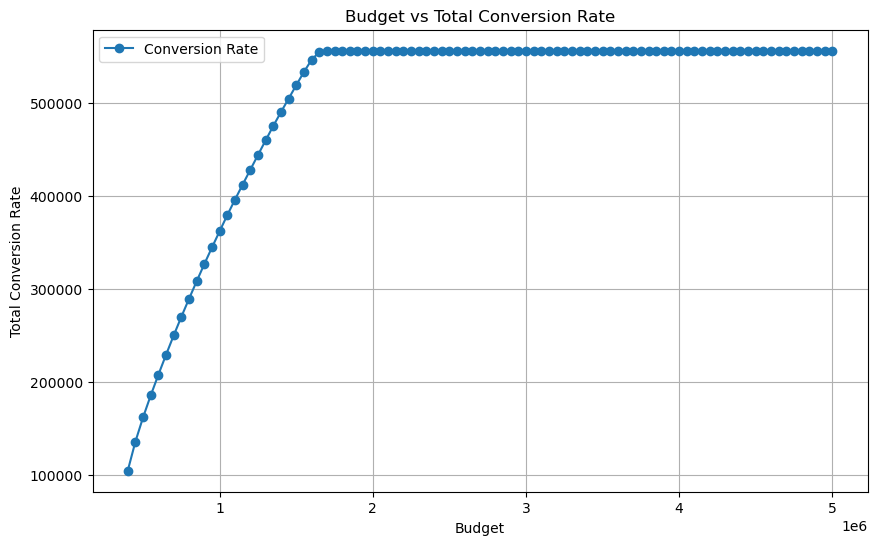

In [33]:
df = pd.read_excel('Social Media Advertising - Aura Align.xlsx')
df = df.sample(n=1000, random_state=42).reset_index(drop=True)


budget_results = budget_limit_analysis_with_constraints_and_logging(
    df, base_budget=100000, budget_step=50000, max_budget=5000000
)

for _, row in budget_results.iterrows():
    print(f"Budget: {row['Budget']}, Binding Constraints: {row['Binding Constraints']}")

plt.figure(figsize=(10, 6))
plt.plot(budget_results['Budget'], budget_results['Total Conversion Rate'], marker='o', label="Conversion Rate")
plt.xlabel("Budget")
plt.ylabel("Total Conversion Rate")
plt.title("Budget vs Total Conversion Rate")
plt.grid(True)
plt.legend()
plt.show()

# With no constrains

In [36]:
df = pd.read_excel('Social Media Advertising - Aura Align.xlsx')
def budget_limit_analysis_with_constraints_and_logging1(
    df, base_budget=0, budget_step=50000, max_budget=2000000
):
    results = []

    num_campaigns = len(df)
    conversion = df['Conversion_Rate'] * df['Clicks']
    cost = df['Acquisition_Cost']
    ROI = df['ROI']
    engagement = df['Engagement_Score']

  
    for budget in range(base_budget, max_budget + budget_step, budget_step):
        model = gb.Model("BudgetLimitAnalysisWithConstraints")
        z = model.addVars(num_campaigns, vtype=gb.GRB.BINARY, name="CampaignSelection")
        x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)

        # Primary objective: Maximize total conversions
        total_conversion = gb.quicksum(conversion[i] * z[i] for i in range(num_campaigns))
        model.setObjective(total_conversion, gb.GRB.MAXIMIZE)

        # Total budget constraint
        model.addConstr(gb.quicksum(cost[i] * z[i] for i in range(num_campaigns)) <= budget, "BudgetConstraint")
        for i in range(num_campaigns):
            model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")

        # Solve the model
        model.optimize()

        # Check if the model was solved optimally
        if model.status == gb.GRB.Status.OPTIMAL:
            print(f"\nBudget: {budget}")
            print("Constraint Slack Analysis:")

            # Get slack values for all constraints
            slack_values = model.getAttr("Slack", model.getConstrs())
            binding_constraints = []

            # Analyze constraints and record slacks
            for constr, slack in zip(model.getConstrs(), slack_values):
                print(f"{constr.ConstrName}: Slack = {slack}")
                if slack == 0:  # Constraint is binding
                    binding_constraints.append(constr.ConstrName)

            # Record results
            total_conversion_rate = model.objVal
            results.append({
                'Budget': budget,
                'Actually Used' : sum(x[i].X for i in range(num_campaigns)) ,
                'Total Conversion Rate': total_conversion_rate,
                'Binding Constraints': binding_constraints,
            })
        else:
            results.append({
                'Budget': budget,
                'Total Conversion Rate': None,
                'Binding Constraints': None,
            })

    return pd.DataFrame(results)

In [37]:
df = pd.read_excel('Social Media Advertising - Aura Align.xlsx')
df = df.sample(n=400, random_state=42).reset_index(drop=True)

budget_results = budget_limit_analysis_with_constraints_and_logging1(
    df, base_budget=0, budget_step=50000, max_budget=2000000
)

for _, row in budget_results.iterrows():
    print(f"Budget: {row['Budget']}, Binding Constraints: {row['Binding Constraints']}")



Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401 rows, 800 columns and 1200 nonzeros
Model fingerprint: 0x81219cc1
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [8e+00, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 401 rows and 800 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%

Budget: 0
Constraint Slack Analysis:
BudgetConstraint: 

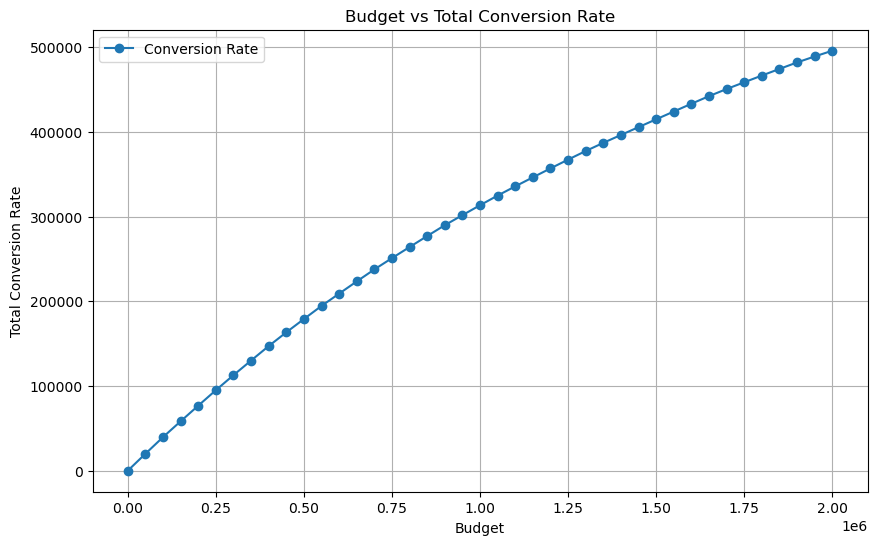

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(budget_results['Budget'], budget_results['Total Conversion Rate'], marker='o', label="Conversion Rate")
plt.xlabel("Budget")
plt.ylabel("Total Conversion Rate")
plt.title("Budget vs Total Conversion Rate")
plt.grid(True)
plt.legend()
plt.show()

In [39]:
df = pd.read_excel('Social Media Advertising - Aura Align.xlsx')
def budget_limit_analysis_with_constraints_and_revenue(
    df, base_budget=0, budget_step=50000, max_budget=2000000
):
    results = []

    num_campaigns = len(df)
    conversion = df['Conversion_Rate'] * df['Clicks']
    cost = df['Acquisition_Cost']
    revenue = df['ROI'] * df['Acquisition_Cost'] + df['Acquisition_Cost']
    engagement = df['Engagement_Score']

  
    for budget in range(base_budget, max_budget + budget_step, budget_step):
        model = gb.Model("BudgetLimitAnalysisWithConstraints")
        z = model.addVars(num_campaigns, vtype=gb.GRB.BINARY, name="CampaignSelection")
        x = model.addVars(num_campaigns, lb=0, name="BudgetAllocation", vtype=GRB.CONTINUOUS)

        # Primary objective: Maximize total conversions
        total_revenue = gb.quicksum(revenue[i] * z[i] for i in range(num_campaigns))
        model.setObjective(total_revenue, gb.GRB.MAXIMIZE)

        # Total budget constraint
        model.addConstr(gb.quicksum(cost[i] * z[i] for i in range(num_campaigns)) <= budget, "BudgetConstraint")
        for i in range(num_campaigns):
            model.addConstr(x[i] == cost[i] * z[i], f"BudgetSelectionConstraint_{i}")

        # Solve the model
        model.optimize()

        # Check if the model was solved optimally
        if model.status == gb.GRB.Status.OPTIMAL:
            print(f"\nBudget: {budget}")
            print("Constraint Slack Analysis:")

            # Get slack values for all constraints
            slack_values = model.getAttr("Slack", model.getConstrs())
            binding_constraints = []

            # Analyze constraints and record slacks
            for constr, slack in zip(model.getConstrs(), slack_values):
                print(f"{constr.ConstrName}: Slack = {slack}")
                if slack == 0:  # Constraint is binding
                    binding_constraints.append(constr.ConstrName)

            # Record results
            total_revenue = model.objVal
            results.append({
                'Budget': budget,
                'Actually Used' : sum(x[i].X for i in range(num_campaigns)) ,
                'Total Revenue': total_revenue,
                'Binding Constraints': binding_constraints,
            })
        else:
            results.append({
                'Budget': budget,
                'Total Revenue': None,
                'Binding Constraints': None,
            })

    return pd.DataFrame(results)

In [40]:
df = pd.read_excel('Social Media Advertising - Aura Align.xlsx')
df = df.sample(n=400, random_state=42).reset_index(drop=True)

budget_results = budget_limit_analysis_with_constraints_and_revenue(
    df, base_budget=0, budget_step=50000, max_budget=2000000
)

for _, row in budget_results.iterrows():
    print(f"Budget: {row['Budget']}, Binding Constraints: {row['Binding Constraints']}")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 401 rows, 800 columns and 1200 nonzeros
Model fingerprint: 0xa731ad3d
Variable types: 400 continuous, 400 integer (400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+04]
  Objective range  [6e+02, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 401 rows and 800 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: -0 
No other solutions better than -0

Optimal solution found (tolerance 1.00e-04)
Best objective -0.000000000000e+00, best bound -0.000000000000e+00, gap 0.0000%

Budget: 0
Constraint Slack Analysis:
BudgetConstraint: 

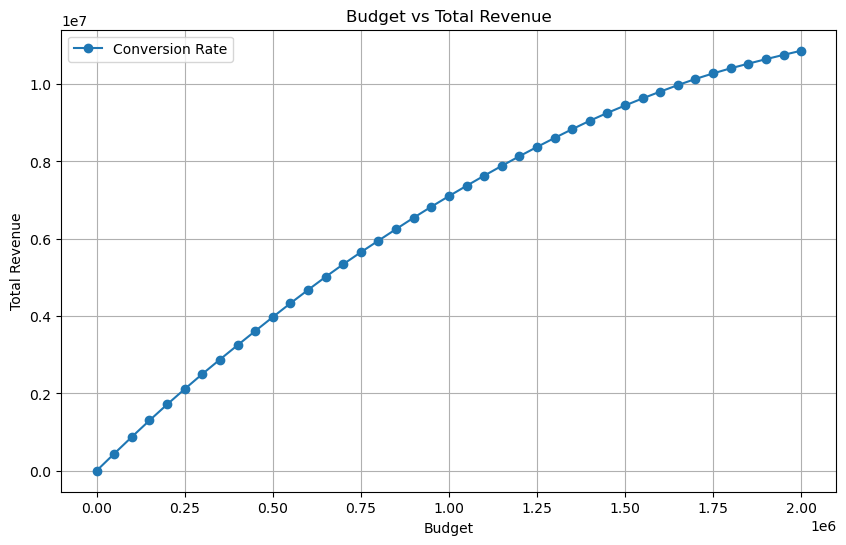

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(budget_results['Budget'], budget_results['Total Revenue'], marker='o', label="Conversion Rate")
plt.xlabel("Budget")
plt.ylabel("Total Revenue")
plt.title("Budget vs Total Revenue")
plt.grid(True)
plt.legend()
plt.show()